In [1]:
from spatialSSL.Dataloader import EgoNetDataloader, FullImageConstracter
from spatialSSL.Utils import split_dataset
from spatialSSL.Training import train
from spatialSSL.Testing import test
import numpy as np

KeyboardInterrupt: 

In [46]:
'''
import os
import scanpy as sc

adata = sc.read("./data/atlas_brain_638850_CCF.h5ad")
# subset the adata
selected_img = np.unique(adata.obs["section"])[0:20]
sub_adata = adata[adata.obs["section"].isin(selected_img)].copy()

# specify the output directory and file
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'sub_20img_adata.h5ad')

# write the sub_adata into a .h5ad file
sub_adata.write(output_file)
'''

In [ ]:
# Create an instance of Full_image_dataloader

#file_path = "./data/img_119670929.h5ad"
file_path = "./data/subset_6img_atlas_brain.h5ad"
#file_path = "./data/atlas_brain_638850_CCF.h5ad"
#file_path = "./data/sub_20img_adata.h5ad"

data_constracter = FullImageConstracter(file_path=file_path, image_col="section", label_col="class_label", include_label=False, radius=20,node_level = 1, batch_size=1)

In [4]:
# Load the data
data_constracter.load_data()

In [5]:
# Construct the graph
graph_list = data_constracter.construct_graph()

Constructing Graphs:   0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
len(graph_list)

20

In [7]:
train_loader, val_loader, test_loader = split_dataset(graph_list,split_percent=(0.6, 0.2, 0.2), batch_size=2)

In [32]:
for x in train_loader:
    print(x)
    break

DataBatch(x=[148410, 550], edge_index=[2, 590848], y=[29681, 550], mask=[148410], cell_type=[2], cell_type_masked=[2], image=[2], batch=[148410], ptr=[3])


In [8]:
# Print out the size of each set to verify
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 12
Validation size: 4
Test size: 4


In [57]:
from torch import nn, optim, Tensor
import torch
from torch_geometric.nn import GCNConv,GATConv
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import r2_score
from torch.nn import LeakyReLU, Dropout
import time

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels)
        self.conv4 = GATConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x

In [36]:


# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the model
model = GAT(550, 550, 550).to(device) # in_channels is set to 100 as an example. Please replace it with your actual feature size.

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#scheduler = StepLR(optimizer, step_size=80, gamma=0.1) # learning rate scheduler

num_epochs = 150
patience = 8

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    targets_list = []
    outputs_list = []

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data.x.float(), data.edge_index.long())
        loss = criterion(outputs[~data.mask], data.y.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        targets_list.append(data.y.cpu().detach())
        outputs_list.append(outputs[~data.mask].cpu().detach())

    return total_loss / len(loader.dataset), r2_score(torch.cat(targets_list).numpy(), torch.cat(outputs_list).numpy())

def validate_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            outputs = model(data.x.float(), data.edge_index.long())
            loss = criterion(outputs[~data.mask], data.y.float())

            total_loss += loss.item() * data.num_graphs
            targets_list.append(data.y.cpu())
            outputs_list.append(outputs[~data.mask].cpu())

    return total_loss / len(loader.dataset), r2_score(torch.cat(targets_list).numpy(), torch.cat(outputs_list).numpy())



In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# usage
model = GAT(550, 550, 550)  # Replace with your actual model
print(f'The model has {count_parameters(model):,} parameters')


The model has 1,216,600 parameters


In [37]:

# Training loop
best_val_loss = float('inf')
best_epoch = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_r2 = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_r2 = validate_one_epoch(model, val_loader, criterion)
    #scheduler.step() # Decrease learning rate by scheduler

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'model_10img_dropout_GAT_data.pt')
    else:
        epochs_no_improve += 1 
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    print(f"Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train r2: {train_r2:.4f},  val loss: {val_loss:.4f}, val r2: {val_r2:.4f}, Time: {time.time()-start_time}s")

print(f"Best val loss: {best_val_loss:.4f}, at epoch {best_epoch+1}")

Epoch 1/150, train loss: 0.8255, train r2: -0.3384,  val loss: 0.6942, val r2: -0.1331, Time: 3.3354499340057373s
Epoch 2/150, train loss: 0.6839, train r2: -0.1838,  val loss: 0.6197, val r2: -0.0686, Time: 3.3251700401306152s
Epoch 3/150, train loss: 0.6281, train r2: -0.0958,  val loss: 0.5790, val r2: -0.0397, Time: 3.3636131286621094s
Epoch 4/150, train loss: 0.5968, train r2: -0.0652,  val loss: 0.5463, val r2: -0.0129, Time: 3.371823787689209s
Epoch 5/150, train loss: 0.5742, train r2: -0.0446,  val loss: 0.5274, val r2: 0.0074, Time: 3.3226749897003174s
Epoch 6/150, train loss: 0.5551, train r2: -0.0265,  val loss: 0.5200, val r2: 0.0173, Time: 3.3312156200408936s
Epoch 7/150, train loss: 0.5402, train r2: -0.0114,  val loss: 0.5058, val r2: 0.0305, Time: 3.3764877319335938s
Epoch 8/150, train loss: 0.5280, train r2: 0.0019,  val loss: 0.4881, val r2: 0.0462, Time: 3.379866600036621s
Epoch 9/150, train loss: 0.5175, train r2: 0.0129,  val loss: 0.4793, val r2: 0.0556, Time: 3.3

In [38]:
from tqdm.auto import tqdm

# Testing phase
model.eval()
total_test_loss = 0
test_targets_list = []
test_outputs_list = []
test_celltypes_list = []

per_celltype = {}

for data in tqdm(test_loader):
    print(data)
    data = data.to(device)
    #print(data)
    with torch.no_grad():
        outputs = model(data.x.float(), data.edge_index.long())
        loss = criterion(outputs[~data.mask], data.y.float())
    total_test_loss += loss.item() * data.num_graphs
    test_celltypes_list.append(data.cell_type_masked)
    test_targets_list.append(data.y.float())
    test_outputs_list.append(outputs[~data.mask])

# Measure and print test loss and R2
test_loss = total_test_loss / len(test_loader.dataset)
test_r2 = r2_score(torch.cat(test_targets_list).cpu().detach().numpy(), torch.cat(test_outputs_list).cpu().detach().numpy())
print(f"Test loss: {test_loss:.4f}, test r2: {test_r2:.4f}")

  0%|          | 0/2 [00:00<?, ?it/s]

DataBatch(x=[123660, 550], edge_index=[2, 382910], y=[24732, 550], mask=[123660], cell_type=[2], cell_type_masked=[2], image=[2], batch=[123660], ptr=[3])
DataBatch(x=[80199, 550], edge_index=[2, 298482], y=[16039, 550], mask=[80199], cell_type=[2], cell_type_masked=[2], image=[2], batch=[80199], ptr=[3])
Test loss: 0.4569, test r2: 0.1503


In [39]:
# Flatten the nested list into a single-dimensional list
flattened_list = [item for sublist in np.concatenate(test_celltypes_list) for item in sublist]

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [40]:
len(flattened_list)

40771

In [41]:
import pandas as pd

preds_test_per_cell = pd.DataFrame({'celltype': flattened_list, 'r2_score': r2_score(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy()), np.transpose(torch.cat(test_outputs_list).cpu().detach().numpy()), multioutput='raw_values')})

preds_test_per_gene = pd.DataFrame({'gene': data_constracter.adata.var_names, 'r2_score': r2_score(torch.cat(test_targets_list).cpu().detach().numpy(), torch.cat(test_outputs_list).cpu().detach().numpy(), multioutput='raw_values')})



In [46]:
preds_test_per_gene

,gene,r2_score
214,Slc17a7,0.686353
118,Igf2,0.637161
293,Ppp1r17,0.631688
31,Gfap,0.630612
208,Zic1,0.606074
...,...,...
353,Kcnip1,-0.055241
501,Blank-49,-0.055839
384,Pif1,-0.057328
523,Blank-41,-0.060323


In [ ]:
# huge class inbalance problem, need to handel -> add weight?
# add pooling

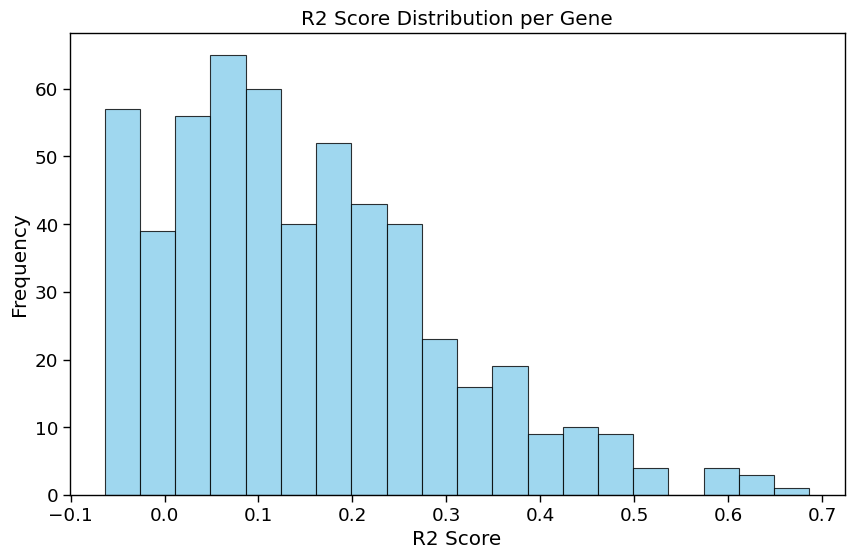

         gene  r2_score
214   Slc17a7  0.686353
118      Igf2  0.637161
293   Ppp1r17  0.631688
31       Gfap  0.630612
208      Zic1  0.606074
..        ...       ...
353    Kcnip1 -0.055241
501  Blank-49 -0.055839
384      Pif1 -0.057328
523  Blank-41 -0.060323
521  Blank-39 -0.063546

[550 rows x 2 columns]


In [44]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(preds_test_per_gene['r2_score'], bins=20, alpha=0.8, color='skyblue', edgecolor='black')
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.show()

# Sorting by r2_score
preds_test_per_gene = preds_test_per_gene.sort_values(by='r2_score', ascending=False)

# Display the sorted DataFrame
print(preds_test_per_gene)


,gene,r2_score
214,Slc17a7,0.686353
118,Igf2,0.637161
293,Ppp1r17,0.631688
31,Gfap,0.630612
208,Zic1,0.606074
...,...,...
353,Kcnip1,-0.055241
501,Blank-49,-0.055839
384,Pif1,-0.057328
523,Blank-41,-0.060323


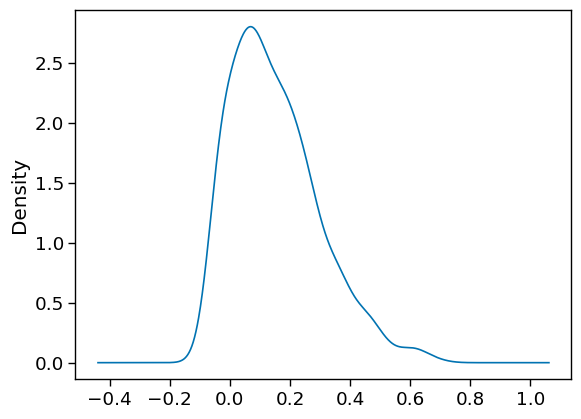

In [42]:
preds_test_per_gene

# plot r2 score distribution per gene, histogram
# density plot
preds_test_per_gene.r2_score.plot.kde()
#preds_test_per_gene.r2_score.plot.hist(bins=20, alpha=0.8)

# plot r2 score distribution per celltype, histogram
#preds_test_per_cell.r2_score.plot.hist(bins=10, alpha=0.8)

# sort by r2 score
preds_test_per_gene.sort_values(by='r2_score', ascending=False, inplace=True)
preds_test_per_gene

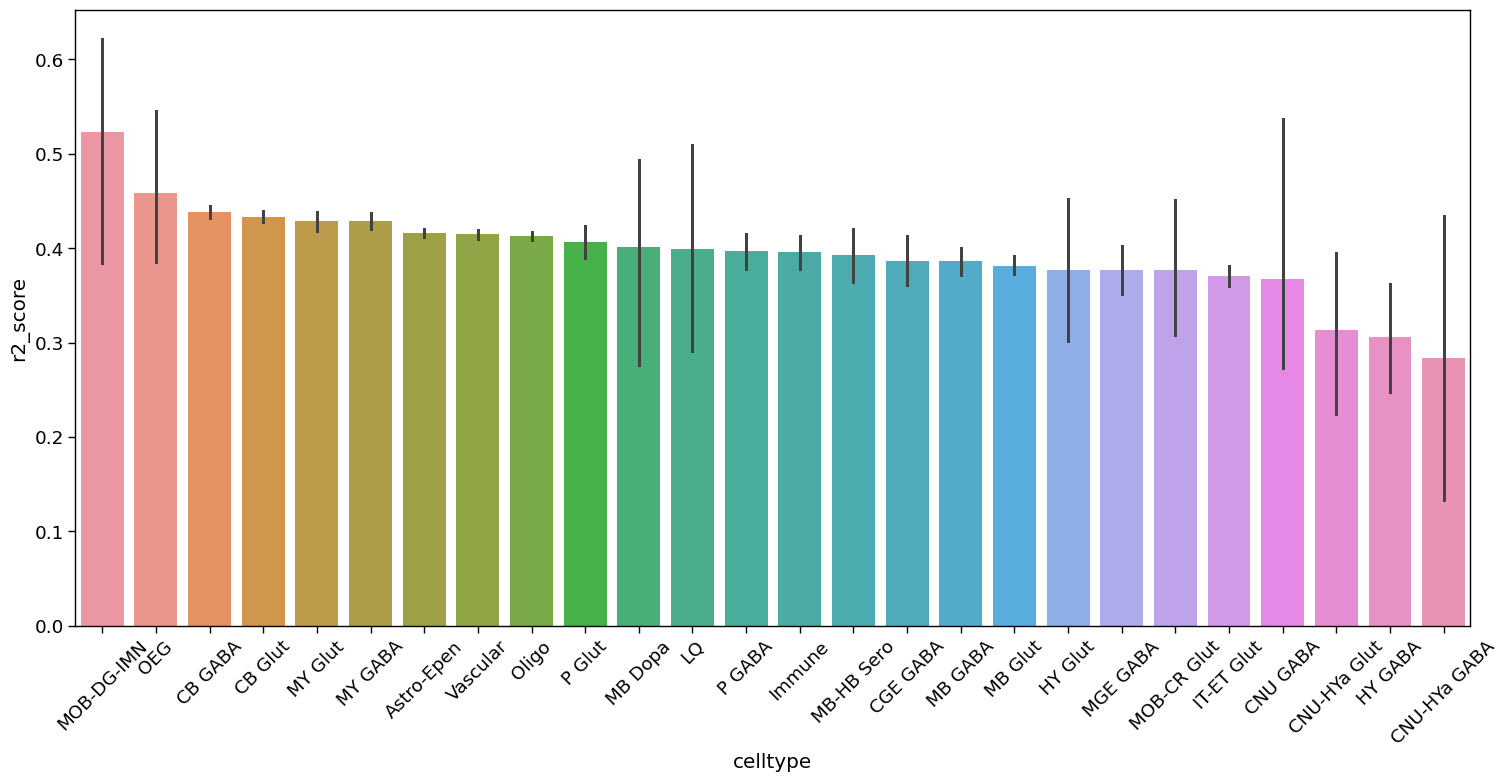

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# set style
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)

# make plot larger
plt.figure(figsize=(18,8))

# rotate x-axis labels
plt.xticks(rotation=45)

# create plot of mean R2 score per celltype
# order bars by mean R2 score

# add avlue counts from adata.obs.class_label.value_counts()
ax = sns.barplot(x="celltype", y="r2_score", data=preds_test_per_cell, order=preds_test_per_cell.groupby('celltype').mean().sort_values(by='r2_score', ascending=False).index)

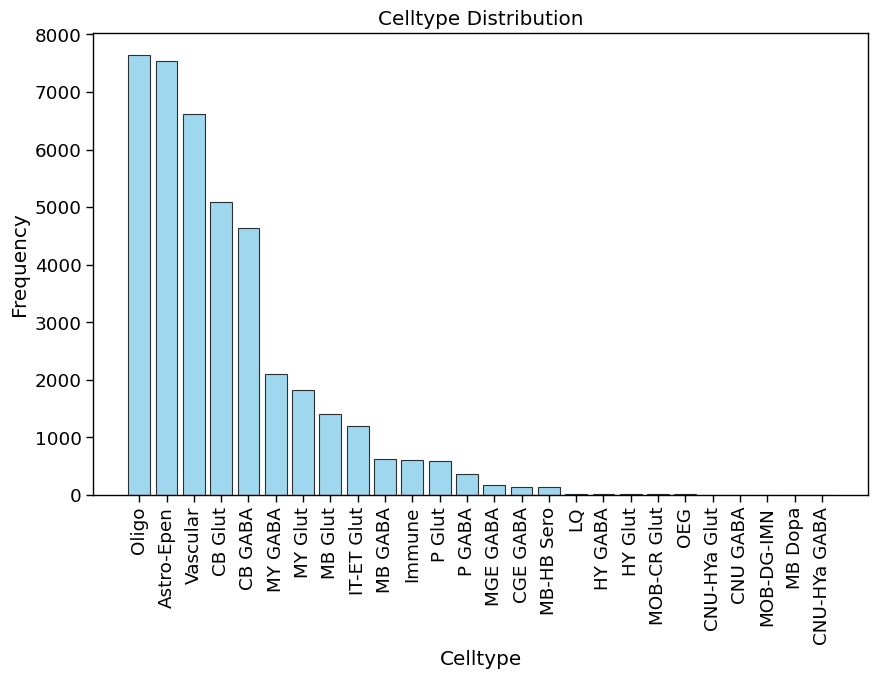

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the frequency of each celltype
celltype_counts = preds_test_per_cell['celltype'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(celltype_counts.index, celltype_counts.values, alpha=0.8, color='skyblue', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xticks(rotation=90)
plt.title('Celltype Distribution')
plt.xlabel('Celltype')
plt.ylabel('Frequency')
plt.show()


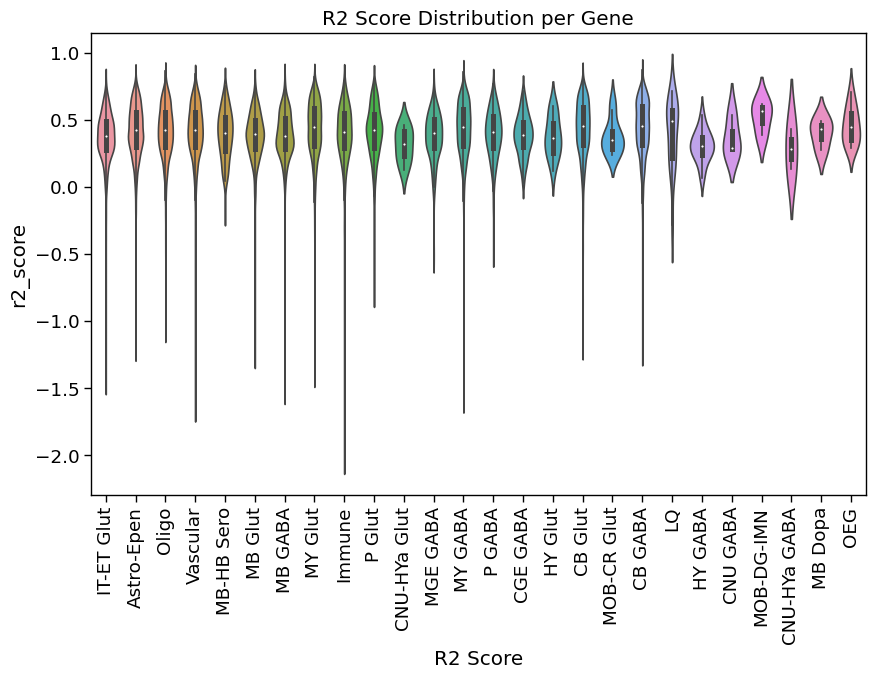

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(x="celltype", y="r2_score", data=preds_test_per_cell)
# rotate x-axis labels
plt.xticks(rotation=90)
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.show()
